## Time series forecasting using Random Forest ensemble technique on Automobile sector stocks.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
df = pd.read_csv('Automobile_mod.csv')

# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date (important for time series data)
df.sort_values('Date', inplace=True)

In [4]:
def plotPredictVsActual(test_df, y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(test_df['Date'], y_test.values, label='Actual')
    plt.plot(test_df['Date'], predictions, label='Predicted')
    plt.title(f'Actual vs Predicted Stock Closing Prices for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Stock Closing Price')
    plt.legend()
    plt.show()

In [5]:
def stockMetrics(y_test, predictions):
    # Calculate and display the metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    nrmse = rmse / (y_test.max() - y_test.min())
    mae = mean_absolute_error(y_test, predictions)
    
    # Calculate actual and predicted growth percentage
    actual_growth = ((y_test.iloc[-1] - y_test.iloc[0]) / y_test.iloc[0]) * 100
    predicted_growth = ((predictions[-1] - predictions[0]) / predictions[0]) * 100
    
    # Store the metrics in the dictionary
    stock_metrics[symbol] = {
        'RMSE': rmse,
        'Normalized RMSE': nrmse,
        'MAE': mae,
        'MSE': mse,
        'Actual Growth %': actual_growth,
        'Predicted Growth %': predicted_growth
    }
    return mse, rmse, nrmse, mae, actual_growth, predicted_growth

Stock: TATAMOTORS
Mean Squared Error: 293.8911968748131
Root Mean Squared Error: 17.14325514232385
Normalized Root Mean Squared Error: 0.1269400602911799
Mean Absolute Error: 10.779544486330105
Actual Growth: -0.3252914068853317
Predicted Growth: 0.0


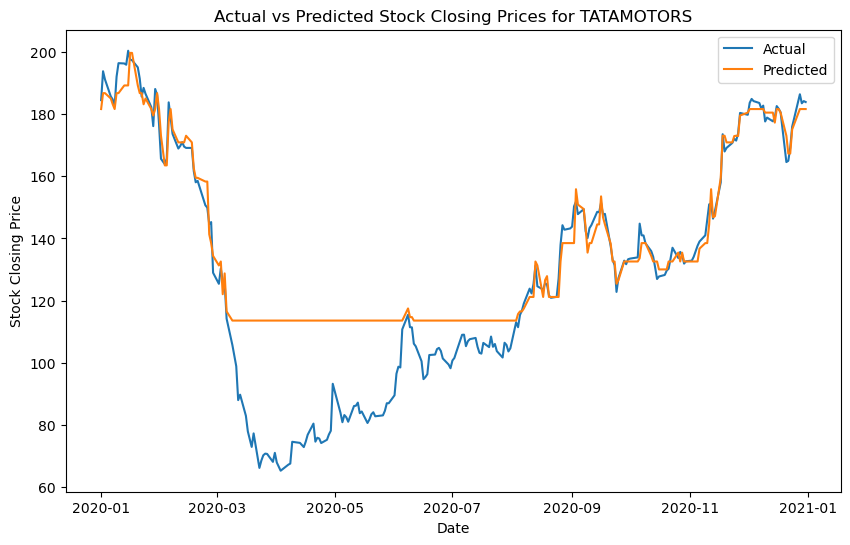

Stock: HEROMOTOCO
Mean Squared Error: 48470.05784506646
Root Mean Squared Error: 220.1591647991663
Normalized Root Mean Squared Error: 0.12279158080212293
Mean Absolute Error: 115.80787427419908
Actual Growth: 27.849376169040706
Predicted Growth: 25.958656927407418


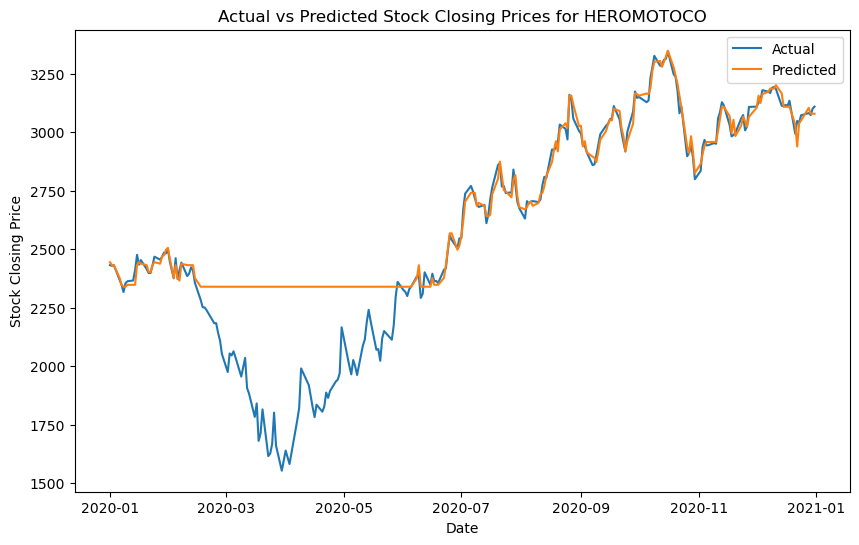

Stock: MARUTI
Mean Squared Error: 7257.798369769834
Root Mean Squared Error: 85.19271312600529
Normalized Root Mean Squared Error: 0.022468506620074453
Mean Absolute Error: 62.46934410135959
Actual Growth: 4.621360285569711
Predicted Growth: 4.5445651391573865


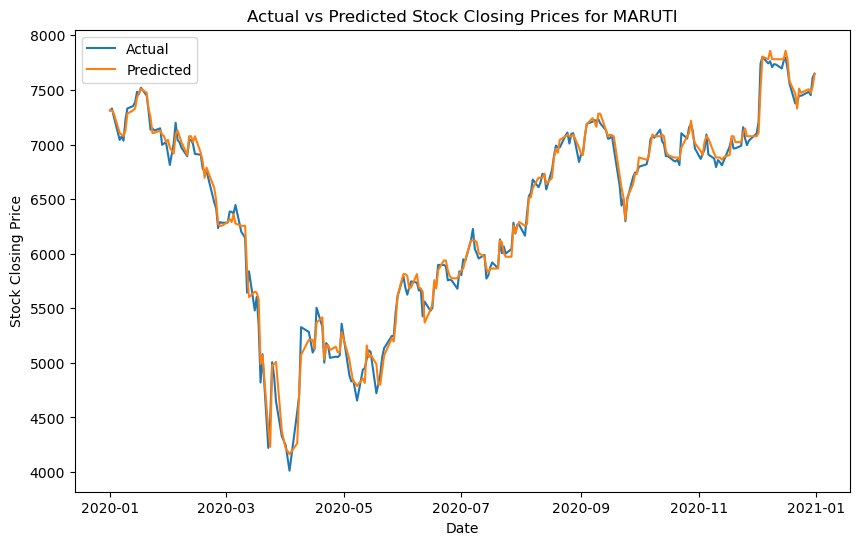

Stock: M&M
Mean Squared Error: 5896.485774598335
Root Mean Squared Error: 76.78857841240672
Normalized Root Mean Squared Error: 0.15800119014898503
Mean Absolute Error: 41.735185749430116
Actual Growth: 34.289973909802455
Predicted Growth: 35.331894220742825


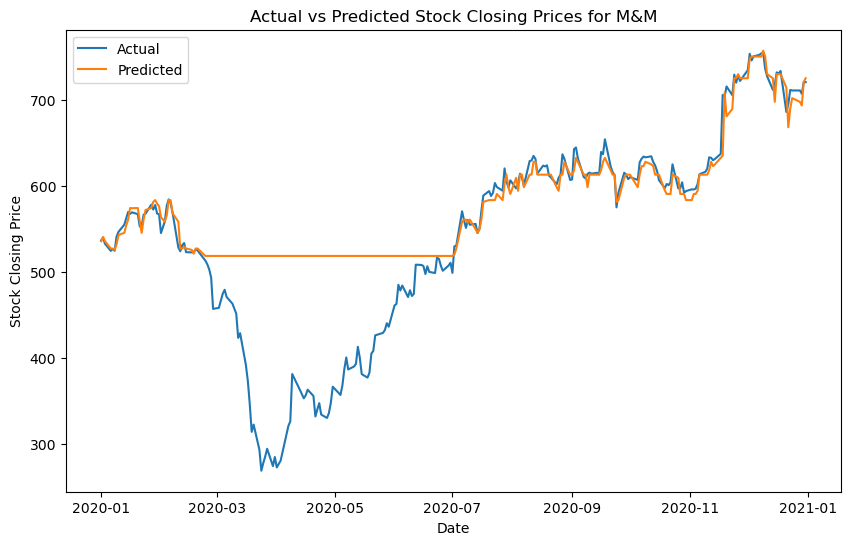

Stock: BAJAJ-AUTO
Mean Squared Error: 3750.999902924994
Root Mean Squared Error: 61.24540719862179
Normalized Root Mean Squared Error: 0.04049015417071386
Mean Absolute Error: 33.44575767496557
Actual Growth: 9.331449795244605
Predicted Growth: 5.769398690416412


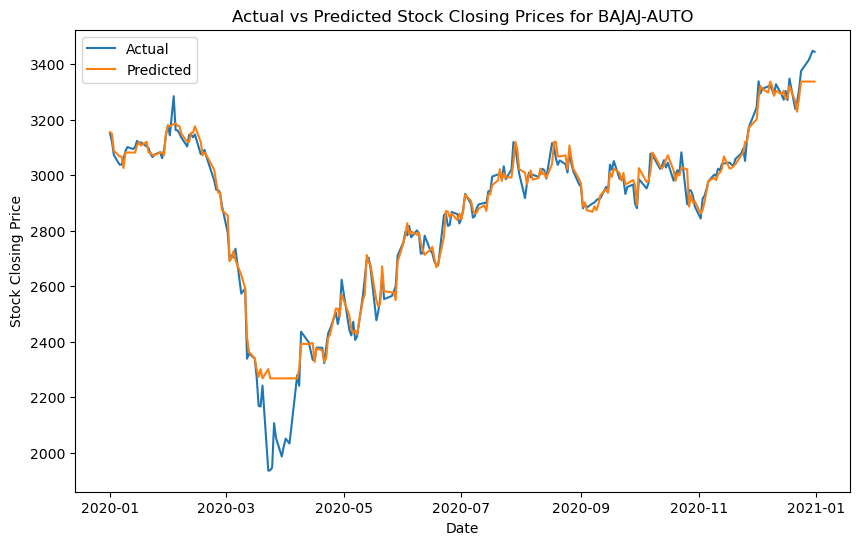

Stock: EICHERMOT
Mean Squared Error: 65307254.58253963
Root Mean Squared Error: 8081.290403304391
Normalized Root Mean Squared Error: 0.40231445229772445
Mean Absolute Error: 5226.921100045928
Actual Growth: -88.53540981527283
Predicted Growth: -29.933995315462127


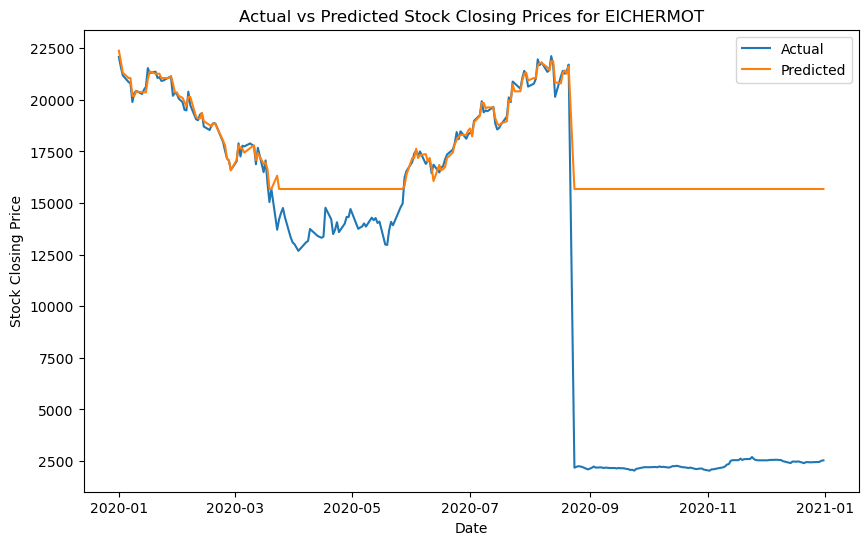

In [6]:
# Get unique stock symbols
stock_symbols = df['Symbol'].unique()
stock_metrics = {}

for symbol in stock_symbols:
    # Filter the DataFrame for the current stock symbol
    stock_df = df[df['Symbol'] == symbol].copy()
    
    # Calculate rolling mean and standard deviation for 50-day and 200-day windows
    stock_df['Rolling_Mean_50'] = stock_df['Close'].rolling(window=50).mean()
    stock_df['Rolling_Std_50'] = stock_df['Close'].rolling(window=50).std()
    stock_df['Rolling_Mean_200'] = stock_df['Close'].rolling(window=200).mean()
    stock_df['Rolling_Std_200'] = stock_df['Close'].rolling(window=200).std()
    
    # Drop rows with NaN values
    stock_df = stock_df.dropna()
    
    # Select features and target
    features = stock_df[['Open', 'High', 'Low', 'Volume', 'Rolling_Mean_50', 'Rolling_Std_50', 'Rolling_Mean_200', 'Rolling_Std_200']]
    target = stock_df['Close']
    
    # Split the data into training and testing sets based on date
    train_df = stock_df[stock_df['Date'] < '2020-01-01']
    test_df = stock_df[(stock_df['Date'] >= '2020-01-01') & (stock_df['Date'] < '2021-01-01')]
    
    X_train, X_test = features.loc[train_df.index], features.loc[test_df.index]
    y_train, y_test = target.loc[train_df.index], target.loc[test_df.index]
    
    # Initialize and train the Random Forest model
    model = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=15, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    mse, rmse, nrmse, mae, actg, predg = stockMetrics(y_test, predictions)
    print(f'Stock: {symbol}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Normalized Root Mean Squared Error: {nrmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Actual Growth: {actg}')
    print(f'Predicted Growth: {predg}')

    plotPredictVsActual(test_df, y_test, predictions)

In [7]:
# Obtaining feature importances from the model
importances = model.feature_importances_

In [8]:
# To get a potentially less biased estimate of feature importance, you can use permutation importance, 
# which is based on the decrease in model performance when the values of a single feature are randomly shuffled.
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
perm_importances = result.importances_mean

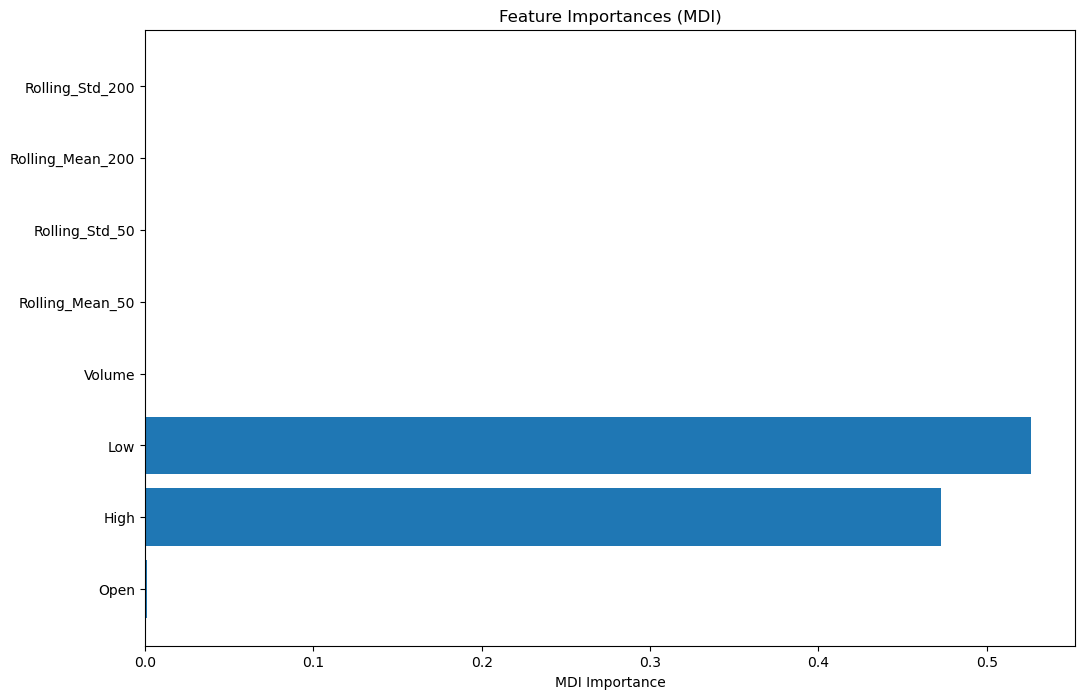

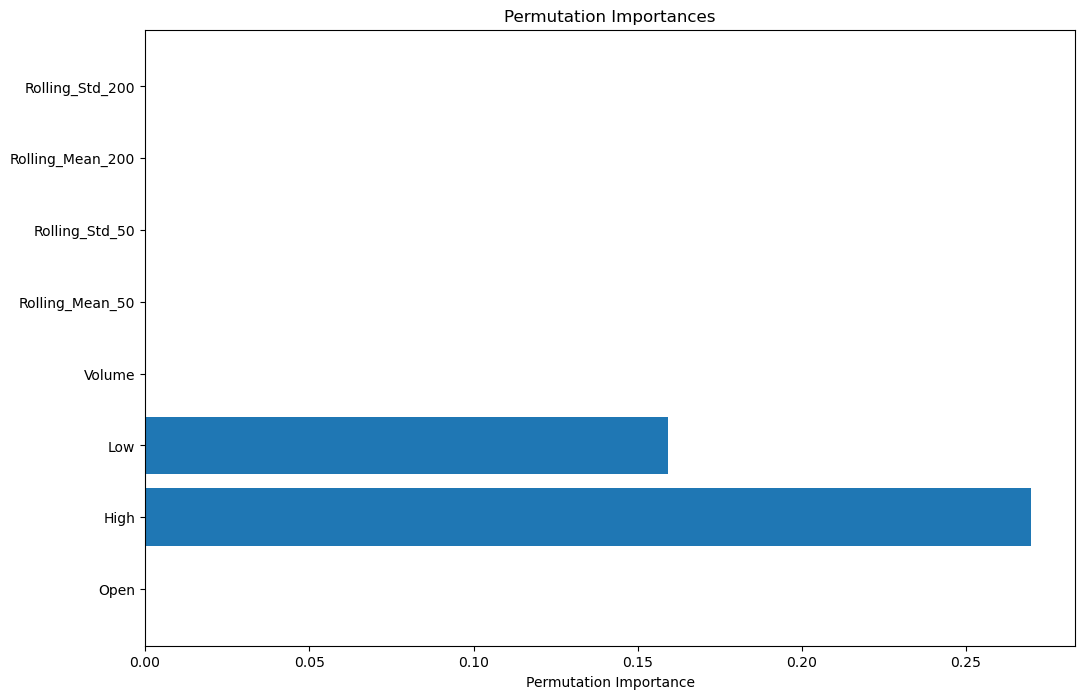

In [9]:
# Plotting MDI importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), X_train.columns)
plt.xlabel('MDI Importance')
plt.title('Feature Importances (MDI)')
plt.show()

# Plotting Permutation Importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(perm_importances)), perm_importances, align='center')
plt.yticks(range(len(perm_importances)), X_train.columns)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importances')
plt.show()